<code style="background:blue;color:blue">**********************************************************************************************************</code>

## Stage: Decide which algorithm and version of the data we are going to use for model training

Additionally, choose:
* if we'll skip scaling the data
* if we'll use full categories instead of dummies
* what fraction of the data we'll use for testing (0.1)
* if the data split will be randomised (it won't!)

In [1]:
FILENAME = 'all_models_except_neural_networks with autoencoding'

#ALGORITHM = 'Linear Regression (Ridge)'
#ALGORITHM = 'KNN'
#ALGORITHM = 'Decision Tree'
#ALGORITHM = 'Random Forest'
#ALGORITHM = 'XG Boost (tree)'
ALGORITHM = 'CatBoost'
#ALGORITHM = 'Light Gradient Boosting'

ALGORITHM_DETAIL = 'random search'
#DATA_DETAIL = ['no scale','no dummies']
#DATA_DETAIL = ['explore param']
#DATA_DETAIL = ['no dummies','autoencoding'] if 'catboost' in ALGORITHM.lower() else ['autoencoding']
DATA_DETAIL = ['autoencoding']
#VERSION = '06'
VERSION = '09'

RANDOM_STATE = 101
TRAINING_SIZE = 0.9

CROSS_VALIDATION_SCORING = 'r2'

print(f'ALGORITHM: {ALGORITHM}')
print(f'ALGORITHM_DETAIL: {ALGORITHM_DETAIL}')
print(f'DATA VERSION: {VERSION}')
print(f'DATA_DETAIL: {DATA_DETAIL}')

model_uses_feature_importances = 'tree' in ALGORITHM.lower() or 'forest' in ALGORITHM.lower() or 'boost' in ALGORITHM.lower()
create_python_script = True

ALGORITHM: CatBoost
ALGORITHM_DETAIL: random search
DATA VERSION: 09
DATA_DETAIL: ['autoencoding']


<code style="background:blue;color:blue">**********************************************************************************************************</code>

## Stage: loading all dependencies



In [2]:
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
import numpy as np
from pandas import DataFrame
import math
from termcolor import colored
from time import time
import sklearn
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
import pickle

import json
from datetime import datetime
import matplotlib.pyplot as plt
import sys
import os

start_timestamp = datetime.now()

module_path = os.path.abspath(os.path.join('..', '..', '..'))
if module_path not in sys.path:
    #sys.path.append(module_path+"\\zfunctions")
    sys.path.append(module_path)

with open('../../z_envs/_envs.json') as f:
    env_vars = json.loads(f.read())

try:
    import google.colab

    run_env = 'colab'
except:
    try:
        run_env = env_vars['notebook_environment']
    except:
        run_env = 'unknown'

if "JPY_PARENT_PID" in os.environ:
    is_jupyter = True
else:
    is_jupyter = False

use_gpu = env_vars.get('use_gpu', False)
debug_mode = env_vars.get('debug_mode', False)
quick_mode = env_vars.get('quick_mode', False)
OVERRIDE_CV = env_vars.get('quick_override_cv_splits', None) if quick_mode else None
OVERRIDE_N_ITER = env_vars.get('quick_override_n_iter', None) if quick_mode else None
OVERRIDE_JOBS = env_vars.get('quick_override_n_jobs', None) if quick_mode else None
OVERRIDE_VERBOSE = 1
#if quick_mode:OVERRIDE_CV, OVERRIDE_N_ITER = 2, 10

already_timed = False
no_dummies = 'no dummies' in DATA_DETAIL
no_scaling = 'no scaling' in DATA_DETAIL
#not_catboost = 'catboost' not in ALGORITHM.lower() or not no_dummies
using_catboost = 'catboost' in ALGORITHM.lower()

if run_env not in ['colab', 'gradient', 'cloud']:
    cloud_run = False
    from functions_b__get_the_data_20221116 import set_csv_directory

    set_csv_directory('final_split')
else:
    cloud_run = True

from functions_0__common_20221116 import get_columns
from functions_b__get_the_data_20221116 import get_combined_dataset, get_source_dataframe
from functions_d1__prepare_cleanse_data_20221116 import tidy_dataset
from functions_d2__transform_enrich_data_20221116 import preprocess, feature_engineer
from functions_d3__prepare_store_data_20221116 import create_train_test_data
from functions_e__train_model_20221116 import get_chosen_model, make_modelling_pipeline, get_cv_params, fit_model_with_cross_validation, get_hyperparameters
from functions_f_evaluate_model_20221116 import get_best_estimator_average_time, get_results, update_results

print(env_vars)

{'notebook_environment': 'gradient', 'use_gpu': True, 'debug_mode': False, 'quick_mode': False, 'quick_override_cv_splits': 2, 'quick_override_n_iter': 10, 'quick_override_n_jobs': 3}


In [20]:
if is_jupyter:
    %pip install tabulate

    if ALGORITHM == 'CatBoost':
        %pip install catboost

    if ALGORITHM == 'Light Gradient Boosting':
        %pip install lightgbm

!pip install pydot
!pip install graphviz

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


#### Include any overrides specific to the algorthm / python environment being used

In [4]:
#running_locally = True
running_locally = run_env == 'local'

if 'forest' in ALGORITHM.lower():
    #OVERRIDE_N_ITER = 5
    OVERRIDE_N_ITER = 50
    if use_gpu:
        #OVERRIDE_JOBS = 8
        OVERRIDE_JOBS = 4

if running_locally:
    if ALGORITHM.lower() in ['random forest', 'xg boost', 'xg boost (linear)', 'xg boost (tree)']:
        OVERRIDE_N_ITER = 3
    elif 'linear regression' in ALGORITHM.lower():
        OVERRIDE_N_ITER = 15
    else:
        OVERRIDE_N_ITER = 5

if ALGORITHM.lower() in ['xg boost', 'xg boost (linear)', 'xg boost (tree)']:
    OVERRIDE_N_ITER = 20

if 'forest' in ALGORITHM.lower() or True:
    OVERRIDE_VERBOSE = 2


<code style="background:blue;color:blue">**********************************************************************************************************</code>

## Stage: defining the model pipeline



In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler


def make_pipeline():
    return Pipeline([
        #('mms', MinMaxScaler()),
        ('std_scaler', StandardScaler()),
        ('model', get_chosen_model(ALGORITHM))
    ])


starter_pipe = make_pipeline()
starter_pipe

Pipeline(steps=[('std_scaler', StandardScaler()), ('model', None)])

<code style="background:blue;color:blue">**********************************************************************************************************</code>

## Stage: get the data

In [6]:
columns, booleans, floats, categories, custom, wildcard = get_columns(version=VERSION)
LABEL = 'Price'

In [7]:
df, retrieval_type = get_source_dataframe(cloud_run, VERSION, folder_prefix='../../../', row_limit=None)
df_orig = df.copy()

if retrieval_type != 'tidy':
    df = tidy_dataset(df, version=int(VERSION))
    df = feature_engineer(df, version=int(VERSION))

    df = df[columns]

loaded data from ../../../https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/df_listings_v09.csv


In [8]:
print(colored(f"features", "blue"), "-> ", columns)
columns.insert(0, LABEL)
print(colored(f"label", "green", None, ['bold']), "-> ", LABEL)

features ->  ['bedrooms', 'bathrooms', 'nearestStation', 'location.latitude', 'location.longitude', 'latitude_deviation', 'longitude_deviation', 'tenure.tenureType']
label ->  Price


In [9]:
df = preprocess(df, version=VERSION)
df = df.dropna()

In [10]:
df.head(5)

,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType,feature__balcony,feature__chain free,feature__no onward chain,feature__off street parking,feature__one bedroom,feature__private balcony,feature__share of freehold,feature__three bedrooms,feature__two bedrooms,feature__two double bedrooms
14520525,550000.0,3.0,1.0,0.274316,51.529950,-0.207020,0.030230,0.102600,LEASEHOLD,0,0,0,0,0,1,0,0,0,0
27953107,400000.0,2.0,2.0,0.305845,51.549390,-0.482600,0.049670,0.378180,LEASEHOLD,1,0,0,0,0,0,0,0,0,1
33593487,579950.0,2.0,1.0,0.438045,51.447180,-0.338770,0.052540,0.234350,FREEHOLD,0,0,1,0,0,0,0,0,0,0
35271294,370000.0,2.0,1.0,0.399307,51.449568,-0.140154,0.050152,0.035734,LEASEHOLD,1,0,0,0,0,0,0,0,0,0
44749111,475000.0,2.0,1.0,0.410550,51.370050,-0.212410,0.129670,0.107990,FREEHOLD,0,0,0,0,0,0,0,0,0,0


In [11]:
X_train_orig, X_test_orig, y_train_orig, y_test_orig, X_train_index, X_test_index, y_train_index, y_test_index, df_features, df_labels = create_train_test_data(
    df,
    categories=categories,
    RANDOM_STATE=RANDOM_STATE, return_index=True,
    drop_nulls=True,
    no_dummies=no_dummies
)

if 'forest' in ALGORITHM.lower() or ALGORITHM.lower() == 'light gradient boosting':
    #y_train_orig = y_train
    y_train = y_train_orig.ravel()

#print(X_train[0])
print(df.shape)
print(X_train_orig.shape, X_test_orig.shape, y_train_orig.shape, y_test_orig.shape, X_train_index.shape,
      X_test_index.shape,
      y_train_index.shape, y_test_index.shape)



(44127, 19)
(39714, 21) (4413, 21) (39714, 1) (4413, 1) (39714, 1) (4413, 1) (39714, 1) (4413, 1)


<code
style = "background:red;color:red" > ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** </code>

## NEW Stage: do autoencoding


In [14]:

import tensorflow as tf
from keras import layers
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

# Tensorflow / Keras
from tensorflow import keras  # for building Neural Networks
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from keras import layers, losses
from keras.datasets import fashion_mnist
from keras.models import Model

print('Keras: %s' % keras.__version__)  # print version
from keras.models import Model, load_model  # for creating a Neural Network Autoencoder model
from keras import Input  # for instantiating a keras tensor
from keras.layers import Dense, LeakyReLU, BatchNormalization  # for adding layers to AE model
from keras.utils import plot_model  # for plotting model diagram

print("Tensorflow version:", tf.__version__)

'''config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config....)'''

n_inputs = X_train_orig.shape[1]  # number of input neurons = the number of features in X_train


Keras: 2.9.0
Tensorflow version: 2.9.1


In [31]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train_orig)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d
X_train_orig.shape

(39714, 21)

In [25]:
from keras.layers import ReLU

# define encoder
visible = Input(shape=(n_inputs,))
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = ReLU()(e)

# define bottleneck
n_bottleneck = n_inputs
bottleneck = Dense(n_bottleneck)(e)

# define decoder
d = Dense(n_inputs*2)(bottleneck)
d = BatchNormalization()(d)
d = ReLU()(d)

# output layer
output = Dense(n_inputs, activation='linear')(d)

# define autoencoder model
model = Model(inputs=visible, outputs=output)

# compile autoencoder model
model.compile(optimizer='adam', loss='mse') 

if False:
    # plot the autoencoder
    plot_model(model, 'autoencoder.png', show_shapes=True)

# fit the autoencoder model to reconstruct input
#history = model.fit(X_train, X_train, epochs=400, batch_size=16, verbose=2, validation_data=(X_test,X_test))
epochs = 20 # 400
history = model.fit(X_train_orig, X_train_orig, epochs=epochs, batch_size=16, verbose=2, validation_data=(X_test_orig, X_test_orig))

Epoch 1/20
2483/2483 - 8s - loss: 19.4596 - val_loss: 7.7111 - 8s/epoch - 3ms/step
Epoch 2/20
2483/2483 - 7s - loss: 0.1000 - val_loss: 0.3072 - 7s/epoch - 3ms/step
Epoch 3/20
2483/2483 - 7s - loss: 0.0671 - val_loss: 0.8314 - 7s/epoch - 3ms/step
Epoch 4/20
2483/2483 - 7s - loss: 0.0520 - val_loss: 2.7687 - 7s/epoch - 3ms/step
Epoch 5/20
2483/2483 - 7s - loss: 0.0438 - val_loss: 0.2976 - 7s/epoch - 3ms/step
Epoch 6/20
2483/2483 - 7s - loss: 0.0351 - val_loss: 0.1056 - 7s/epoch - 3ms/step
Epoch 7/20
2483/2483 - 7s - loss: 0.0305 - val_loss: 1.7751 - 7s/epoch - 3ms/step
Epoch 8/20
2483/2483 - 7s - loss: 0.0271 - val_loss: 0.2963 - 7s/epoch - 3ms/step
Epoch 9/20
2483/2483 - 7s - loss: 0.0250 - val_loss: 0.1164 - 7s/epoch - 3ms/step
Epoch 10/20
2483/2483 - 7s - loss: 0.0217 - val_loss: 0.0965 - 7s/epoch - 3ms/step
Epoch 11/20
2483/2483 - 7s - loss: 0.0190 - val_loss: 0.3308 - 7s/epoch - 3ms/step
Epoch 12/20
2483/2483 - 7s - loss: 0.0179 - val_loss: 0.4941 - 7s/epoch - 3ms/step
Epoch 13/20


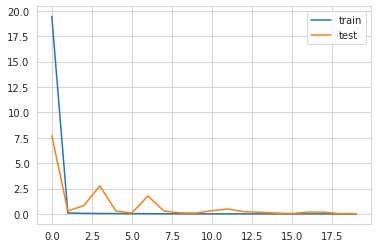

In [27]:

from matplotlib import pyplot
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [14]:

if False:
    # Load the model from file
    from keras.models import Model, load_model  # for creating a Neural Network Autoencoder model

    try:
        main_dir = os.path.dirname(sys.path[0])
        encoder = load_model(main_dir + f'/data/encoder_v{VERSION}.h5')
    except:
        encoder = load_model('data/encoder_v{VERSION}.h5')


Tensorflow version: 2.9.1


In [23]:


if False:
    #--- Define Shapes
    n_inputs = X_train_orig.shape[1]  # number of input neurons = the number of features in X_train
    n_bottleneck = (round(float(n_inputs) / 1.0))  # bottleneck to have half the number of neurons

    #--- Input Layer
    visible = Input(shape=(n_inputs,), name='Input-Layer')  # Specify input shape

    #--- Encoder Layer
    #e = Dense(units=n_inputs, name='Encoder-Layer')(visible)
    #e = BatchNormalization(name='Encoder-Layer-Normalization')(e)
    #e = LeakyReLU(name='Encoder-Layer-Activation')(e)

    #--- Bottleneck
    #bottleneck = Dense(units=n_bottleneck, name='Bottleneck-Layer')(e)

    #--- Decoder Layer
    #d = Dense(units=n_inputs, name='Decoder-Layer')(bottleneck)
    #d = BatchNormalization(name='Decoder-Layer-Normalization')(d)
    #d = LeakyReLU(name='Decoder-Layer-Activation')(d)

    #--- Output layer
    # REPLACED output = Dense(units=n_inputs, activation='linear', name='Output-Layer')(d)
    output = Dense(units=n_inputs, activation='linear', name='Output-Layer')(visible)

    # Define autoencoder model
    model = Model(inputs=visible, outputs=output, name='Autoencoder-Model')

    # Compile autoencoder model
    model.compile(optimizer='adam', loss='mse')

    # Print model summary
    print(model.summary())

    # Plot the autoencoder model diagram
    from keras.utils import plot_model  # for plotting model diagram

    try:
        plot_model(model, to_file=main_dir + f'/pics/Autoencoder_{VERSION}.png', show_shapes=True, dpi=300)
    except:
        plot_model(model, to_file=f'./pics/Autoencoder_{VERSION}.png', show_shapes=True, dpi=300)
elif False:

    input_size = X_train_orig.shape[1]  # number of input neurons = the number of features
    latent_size = 16

    enc_input = Input(shape=(input_size,))

    enc_dense1 = Dense(units=256, activation="relu")(enc_input)
    enc_activ1 = LeakyReLU()(enc_dense1)
    enc_dense2 = Dense(units=latent_size)(enc_activ1)
    enc_output = LeakyReLU()(enc_dense2)
    encoder = Model(enc_input, enc_output)
else:

    latent_dim = 64


    class Autoencoder(Model):
        def __init__(self, latent_dim):
            super(Autoencoder, self).__init__()
            self.latent_dim = latent_dim
            self.encoder = tf.keras.Sequential([
                #layers.Flatten(),
                layers.Dense(latent_dim, activation='relu'),
            ])
            self.decoder = tf.keras.Sequential([
                #layers.Dense(784, activation='sigmoid'),
                layers.Dense(21, activation='sigmoid'),
                #layers.Reshape((28, 28))
                #layers.Reshape((21, 21))
            ])

        def call(self, x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return decoded

    autoencoder = Autoencoder(latent_dim)

    #--
    autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
    #--
    x_train = X_train_orig
    x_test = X_test_orig

    autoencoder.fit(x_train, x_train,
                    epochs=10,
                    shuffle=True,
                    validation_data=(x_test, x_test))


encoder.summary()

Tensorflow/Keras: 2.9.0


TypeError: int() argument must be a string, a bytes-like object or a number, not 'tuple'

In [ ]:
main_dir

In [ ]:
# Define an encoder model without the decoder
# REPLACED encoder = Model(inputs=visible, outputs=bottleneck)
if False:
    encoder = Model(inputs=visible, outputs=visible)

# Compile encoder model
encoder.compile(optimizer='adam', loss='mse')

# Save the encoder model to file
try:
    main_dir = os.path.dirname(sys.path[0])
    encoder.save(main_dir + f'/data/encoder_v{VERSION}.h5')
    print('performed operation to main_dir: SAVE')
except:
    print('failed to perform operation to main_dir: SAVE')
    main_dir = '.'
    encoder.save(main_dir + f'/data/encoder_v{VERSION}.h5')
    print('performed operation to local/relative: SAVE')

# Plot the autoencoder model diagram
try:
    main_dir = os.path.dirname(sys.path[0])
    plot_model(encoder, to_file=main_dir + f'/pics/Encoder_only_v{VERSION}.png', show_shapes=True, dpi=300)
    print('performed operation to main_dir: ENCODER PIC')
except:
    print('failed to perform operation to main_dir: ENCODER PIC')
    main_dir = '.'
    plot_model(encoder, to_file=main_dir + f'/pics/Encoder_only_v{VERSION}.png', show_shapes=True, dpi=300)
    print('performed operation to local/relative: ENCODER PIC')



In [ ]:
df.head(30)

In [ ]:
print(X_train_orig.shape, X_test_orig.shape, y_train_orig.shape, y_test_orig.shape, X_train_index.shape,
      X_test_index.shape,
      y_train_index.shape, y_test_index.shape)

physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

#config = tf.compat.v1.ConfigProto()
#config.gpu_options.allow_growth = True
#session = tf.compat.v1.Session(config=config)

# Encode train and test data
X_train = encoder.predict(X_train_orig)
X_test = encoder.predict(X_test_orig)
#X_train = X_train_orig
#X_test = X_test_orig
y_train = y_train_orig
y_test = y_test_orig

#print(X_train[0])
print(df.shape)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape,
      y_train_index.shape, y_test_index.shape)


End of autoencoding segment

<code
style = "background:black;color:black" > ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** </code>

In [ ]:
#imputer = SimpleImputer(strategy='mean')
#imputer.fit(X_train[6])
#X_train[6] = imputer.transform(X_train[6])

In [23]:
starter_model = starter_pipe[-1]

In [24]:
X_train

array([[ 2.9657922 ,  3.0582008 ,  5.4465423 , ...,  4.8655086 ,
        -0.49992034, -1.2315034 ],
       [ 3.2100427 ,  3.2315102 ,  5.58276   , ...,  4.472334  ,
        -0.37812153, -1.3427309 ],
       [ 3.1220367 ,  3.2272813 ,  5.5096564 , ...,  4.526104  ,
        -0.37245423, -1.3632572 ],
       ...,
       [ 2.8305044 ,  3.2613297 ,  5.428504  , ...,  4.8105607 ,
        -0.40485314, -1.2414722 ],
       [ 3.1800761 ,  3.26997   ,  5.5954366 , ...,  4.4748464 ,
        -0.36723316, -1.3561618 ],
       [ 2.8507266 ,  3.1108289 ,  5.413883  , ...,  5.114644  ,
        -0.55374205, -1.1601348 ]], dtype=float32)

<code style="background:blue;color:blue">**********************************************************************************************************</code>

## Stage:
* #### retrieve the hyperparameters for this model, and
* #### train the model



In [25]:
options_block = get_hyperparameters(ALGORITHM, use_gpu, prefix='../../../')

if 'explore param' in DATA_DETAIL:
    def automl_step(param_options, vary):
        for key2, value in param_options.items():
            #print(key2, value, vary)
            if key2 != vary and key2 != 'model__' + vary:
                try:
                    param_options[key2] = [param_options[key2][0]]
                except:
                    # value probably wasn't an list of options
                    param_options[key2] = [param_options[key2]]
        return param_options


    #options_block = automl_step(options_block, "model__epochs")
    explore_param = "n_estimators"
    options_block = automl_step(options_block, explore_param)

    ALGORITHM_DETAIL = 'grid search (implied)'

param_options, cv, n_jobs, refit, n_iter, verbose = get_cv_params(options_block, debug_mode=debug_mode,
                                                                  override_cv=OVERRIDE_CV,
                                                                  override_niter=OVERRIDE_N_ITER,
                                                                  override_njobs=OVERRIDE_JOBS,
                                                                  override_verbose=OVERRIDE_VERBOSE
                                                                  )

if not using_catboost and len(param_options.keys()) > 2 and not already_timed and debug_mode:
    already_timed = True
    % timeit starter_pipe.fit(X_train, y_train)

print("cv:", cv, "n_jobs:", n_jobs, "refit:", refit, "n_iter:", n_iter, "verbose:", verbose)
#print('\n\nHyperparameters:')
#param_options if not using_catboost else options_block

cv: 3 n_jobs: 3 refit: True n_iter: 100 verbose: 2


In [26]:
no_dummies


False

In [27]:
def fit_model_with_cross_validation(gs, X_train, y_train, fits):
    pipe_start = time()
    cv_result = gs.fit(X_train, y_train)
    gs.fit(X_train, y_train)
    pipe_end = time()
    average_time = round((pipe_end - pipe_start) / (fits), 2)

    print(f"Total fit/CV time      : {int(pipe_end - pipe_start)} seconds   ({pipe_start} ==> {pipe_end})")
    print()
    print(
        f'average fit/score time = {round(cv_result.cv_results_["mean_fit_time"].mean(), 2)}s/{round(cv_result.cv_results_["mean_score_time"].mean(), 2)}s')
    print(
        f'max fit/score time     = {round(cv_result.cv_results_["mean_fit_time"].max(), 2)}s/{round(cv_result.cv_results_["mean_score_time"].max(), 2)}s')
    print(f'refit time             = {round(cv_result.refit_time_, 2)}s')

    #return cv_result, average_time, cv_result.refit_time_, len(cv_result.cv_results_["mean_fit_time"])
    return average_time, cv_result.refit_time_, len(cv_result.cv_results_["mean_fit_time"])


if not using_catboost:
    if ALGORITHM_DETAIL == 'grid search' or ALGORITHM_DETAIL == 'grid search (implied)':
        print('grid search (or implied)')
        crossval_runner = GridSearchCV(
            estimator=starter_pipe,
            param_grid=param_options,
            cv=cv, n_jobs=n_jobs,  # get the AVX/AVX2 info if use n_jobs > 2
            verbose=verbose, scoring=CROSS_VALIDATION_SCORING,
            refit=refit,
            return_train_score=True,  #n_iter=n_iter,
            #error_score='raise'
        )
    else:
        print('random search')
        crossval_runner = RandomizedSearchCV(
            estimator=starter_pipe,
            param_distributions=param_options,
            cv=cv, n_jobs=n_jobs,  # get the AVX/AVX2 info if use n_jobs > 2
            verbose=verbose, scoring=CROSS_VALIDATION_SCORING,
            refit=refit,
            return_train_score=True,  #n_iter=n_iter,
            n_iter=n_iter,  # 1, #3
            #error_score='raise'
        )
    cv_average_fit_time, cv_best_model_fit_time, total_fits = fit_model_with_cross_validation(
        crossval_runner, X_train, y_train, fits=cv * n_iter)

else:
    from catboost import CatBoostRegressor, Pool

    if no_dummies:
        pool_Xtrain = Pool(X_train, cat_features=[7], label=y_train)
        pool_Xtest = Pool(X_test, cat_features=[7], label=y_test)
    else:
        pool_Xtrain = Pool(X_train, cat_features=[], label=y_train)
        pool_Xtest = Pool(X_test, cat_features=[], label=y_test)
    import sys

    starter_model = model = CatBoostRegressor(iterations=3, depth=3, learning_rate=0.1, loss_function='RMSE',
                                              objective='RMSE')

    output = starter_model.randomized_search(options_block,  # param_options,
                                             X=pool_Xtrain,  # X_train,
                                             #y=y_train,
                                             #cat_features=[],
                                             cv=5,
                                             n_iter=100,
                                             partition_random_seed=101,
                                             calc_cv_statistics=True,
                                             #search_by_train_test_split=True,
                                             refit=True,
                                             shuffle=True,
                                             stratified=None,
                                             #train_size=0.8,
                                             #train_size=1,
                                             verbose=True,
                                             plot=True,
                                             log_cout=sys.stdout,
                                             log_cerr=sys.stderr)

    cat_params, cat_cv_results = output['params'], output['cv_results']
    crossval_runner = {"best_params_": cat_params, "cv_results_": cat_cv_results, "best_estimator_": None}
crossval_runner


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 97353.2130188	test: 97850.4894833	best: 97850.4894833 (0)	total: 55.5ms	remaining: 111ms
1:	learn: 89708.5471023	test: 90293.4964977	best: 90293.4964977 (1)	total: 65.3ms	remaining: 32.6ms
2:	learn: 87584.6443398	test: 88545.4359842	best: 88545.4359842 (2)	total: 71.7ms	remaining: 0us

bestTest = 88545.43598
bestIteration = 2

0:	loss: 88545.4359842	best: 88545.4359842 (0)	total: 394ms	remaining: 39s
0:	learn: 434315.9753366	test: 434794.1387181	best: 434794.1387181 (0)	total: 8.76ms	remaining: 17.5ms
1:	learn: 430182.2063659	test: 430666.6670491	best: 430666.6670491 (1)	total: 17.9ms	remaining: 8.96ms
2:	learn: 426124.7270693	test: 426611.4409976	best: 426611.4409976 (2)	total: 26.9ms	remaining: 0us

bestTest = 426611.441
bestIteration = 2

1:	loss: 426611.4409976	best: 88545.4359842 (0)	total: 424ms	remaining: 20.8s
0:	learn: 396969.5837410	test: 397510.8644334	best: 397510.8644334 (0)	total: 10.2ms	remaining: 20.5ms
1:	learn: 359645.2767768	test: 360246.2416040	best: 36024

{'best_params_': {'depth': 10, 'l2_leaf_reg': 1, 'learning_rate': 0.9},
 'cv_results_': defaultdict(list,
             {'iterations': [0, 1, 2],
              'test-RMSE-mean': [103728.10679710799,
               88043.94005041782,
               85380.58368092238],
              'test-RMSE-std': [733.7020103162439,
               620.6120382503689,
               446.2372682463485],
              'train-RMSE-mean': [102259.96746231492,
               85820.02049049013,
               82617.39583305006],
              'train-RMSE-std': [67.44169034317501,
               198.06923455408784,
               271.0949630625529]}),
 'best_estimator_': None}

In [28]:
if ALGORITHM_DETAIL == 'grid search' or ALGORITHM_DETAIL == 'grid search (implied)':
    print(crossval_runner.best_params_)

<code style="background:blue;color:blue">**********************************************************************************************************</code>

## Stage: Get the results and print some graphs



In [29]:
if not using_catboost:
    best_estimator_pipe = crossval_runner.best_estimator_
    cv_results_df = pd.DataFrame(crossval_runner.cv_results_).sort_values('rank_test_score')

    print("Best Params\n", crossval_runner.best_params_, "\n---------------------")

    if debug_mode:
        print("CV results\n", crossval_runner.cv_results_, "\n---------------------")
        #print("Best Params\n",crossval_runner["best_params_"], "\n---------------------")

else:
    print(cat_params)
    print(cat_cv_results)

{'depth': 10, 'l2_leaf_reg': 1, 'learning_rate': 0.9}
defaultdict(<class 'list'>, {'iterations': [0, 1, 2], 'test-RMSE-mean': [103728.10679710799, 88043.94005041782, 85380.58368092238], 'test-RMSE-std': [733.7020103162439, 620.6120382503689, 446.2372682463485], 'train-RMSE-mean': [102259.96746231492, 85820.02049049013, 82617.39583305006], 'train-RMSE-std': [67.44169034317501, 198.06923455408784, 271.0949630625529]})


In [30]:
key = f'{ALGORITHM} (v{VERSION})'.lower()

if not using_catboost:
    cv_results_df['params2'] = cv_results_df['params'].apply(lambda l: '/'.join([str(c) for c in l.values()]))

    cv_columns = ['params2', 'rank_test_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time', 'params']
    # if 'Neural' not in ALGORITHM:
    #     cv_columns.insert(2, 'mean_train_score')
    cv_results_df_full_sorted = cv_results_df.sort_values('rank_test_score')[cv_columns].reset_index(drop=True)

    cv_results_df_sorted = cv_results_df_full_sorted[cv_results_df_full_sorted['mean_test_score'] > -2]
    if len(cv_results_df_sorted) != len(cv_results_df_full_sorted):
        print(-len(cv_results_df_sorted) + len(cv_results_df_full_sorted), "fits were total failures")
        total_fits = len(cv_results_df_sorted)

if not using_catboost:
    if is_jupyter: display(cv_results_df_sorted)

    orig_debug_mode, orig_display_df_cols = debug_mode, pd.get_option('display.max_columns')
    debug_mode = True
    pd.set_option('display.max_columns', None)
    if debug_mode:
        debug_cols = ['rank_test_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time']
        debug_cols.extend([c for c in cv_results_df.columns if 'param' in c and c != 'params'])

    cv_results_df_summary = cv_results_df[debug_cols].head(7)
    cv_results_df_summary.set_index('rank_test_score', inplace=True)

    if is_jupyter: display(cv_results_df_summary)

<code style="background:blue;color:blue">**************</code>

#### Mini Stage: Make predictions



In [31]:
if not using_catboost:
    y_pred = best_estimator_pipe.predict(X_test)
else:
    y_pred = starter_model.predict(pool_Xtest)

In [32]:
y_pred = y_pred.reshape((-1, 1))

R2 = r2_score(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
print('-' * 10 + ALGORITHM + '-' * 10)
print('R square Accuracy', R2)
print('Mean Absolute Error Accuracy', MAE)
print('Mean Squared Error Accuracy', MSE)
print('Root Mean Squared Error', RMSE)

----------CatBoost----------
R square Accuracy 0.40887673447009765
Mean Absolute Error Accuracy 65989.84460933224
Mean Squared Error Accuracy 6677568184.052788
Root Mean Squared Error 81716.3887115234


In [33]:
compare = np.hstack((y_test_index, y_test, y_pred))
compare_df = DataFrame(compare, columns=['reference', 'actual', 'predicted'])
compare_df['difference'] = abs(compare_df['actual'] - compare_df['predicted'])
compare_df['diff 1 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['actual'] * 100)
compare_df['diff 2 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['predicted']) * 100
compare_df['reference'] = compare_df['reference'].astype(int)
compare_df.set_index('reference', inplace=True)

combined = compare_df.merge(df[columns], how='inner', left_index=True, right_index=True).sort_values(['diff 1 %'],
                                                                                                     ascending=False)
#pd.options.display.float_format = '{:.4f}'.format
combined[['predicted', 'actual', 'Price', 'bedrooms', 'bathrooms']] = combined[
    ['predicted', 'actual', 'Price', 'bedrooms', 'bathrooms']].astype(int)
combined['bedrooms'] = combined['bedrooms'].astype(int)
combined

,actual,predicted,difference,diff 1 %,diff 2 %,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType
122265818,160000,513253,353253.898726,220.783687,68.826345,160000,3,1,0.166024,51.510420,-0.037730,0.010700,0.066690,FREEHOLD
85667184,122000,364145,242145.430035,198.479861,66.496902,122000,1,1,0.838896,51.540462,-0.280301,0.040742,0.175881,LEASEHOLD
109722224,108000,300410,192410.465341,178.157838,64.049189,108000,1,1,0.302667,51.406803,-0.261328,0.092917,0.156908,LEASEHOLD
83639617,190000,493635,303635.738101,159.808283,61.510080,190000,2,2,0.162816,51.491264,0.064660,0.008456,0.169080,LEASEHOLD
122821142,170000,432732,262732.750854,154.548677,60.714783,170000,2,1,0.093936,51.430690,0.024020,0.069030,0.128440,LEASEHOLD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106920899,425000,425109,109.180280,0.025689,0.025683,425000,2,1,0.549148,51.568373,0.190009,0.068653,0.294429,FREEHOLD
120980768,385000,384939,60.081991,0.015606,0.015608,385000,1,1,0.414863,51.519230,-0.026830,0.019510,0.077590,LEASEHOLD
114985145,450000,449933,66.582972,0.014796,0.014798,450000,2,1,0.237889,51.410737,-0.297556,0.088983,0.193136,LEASEHOLD
125382539,375000,374954,45.012491,0.012003,0.012005,375000,1,1,0.286933,51.489852,-0.304286,0.009868,0.199866,LEASEHOLD


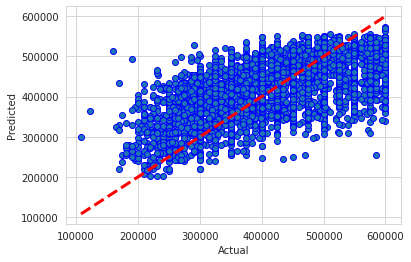

In [34]:
best_model_fig, best_model_ax = plt.subplots()
best_model_ax.scatter(y_test, y_pred, edgecolors=(0, 0, 1))
best_model_ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
best_model_ax.set_ylabel('Predicted')
best_model_ax.set_xlabel('Actual')
#ax.title.set_text(f'CV Chosen best option ({calculated_best_pipe[1]})')

plt.show()

In [35]:
if not using_catboost:
    def custom_model_and_predictions(model, graph_params, X_train, y_train, X_test):
        graph_model = model
        graph_model.set_params(**graph_params)
        graph_model.fit(X_train, y_train)
        y_pred_graph = model.predict(X_test)

        return model, y_pred_graph


    best_model_count = 10 if not quick_mode else 2
    best_model_count = 3 if not quick_mode else 1
    best_models = {}
    best_model_predictions = {}
    best_model_scores = {}

    showable_increment = total_fits // (4 if not quick_mode else 2)
    if showable_increment == 0: showable_increment = 1
    for i in range(0, total_fits, showable_increment):
        if debug_mode: print(f'{i} ==> {i}')

        if i == 0:
            fitted_graph_model = crossval_runner.best_estimator_
            y_pred_graph = y_pred
        else:
            graph_pipe_params = cv_results_df_sorted['params'][i]
            print(graph_pipe_params)
            # would always return the best! graph_pipe_params = cv_results_df_sorted.loc[cv_results_df_sorted['rank_test_score'] == 1, 'params'].values[0]

            graph_params = {}
            for key2, value in graph_pipe_params.items():
                graph_params[key2.replace('model__', '')] = value

            fitted_graph_model, y_pred_graph = custom_model_and_predictions(make_pipeline(), graph_pipe_params, X_train,
                                                                            y_train, X_test)

        best_models[i] = fitted_graph_model[-1].get_params()
        best_model_predictions[i] = y_pred_graph
        best_model_scores[i] = fitted_graph_model.score(X_test, y_test)

    if debug_mode: print(f'{-1} ==> {-1}')
    graph_pipe_params = cv_results_df_sorted['params'][total_fits - 1]
    print(graph_pipe_params)
    graph_params = {}
    for key2, value in graph_pipe_params.items():
        graph_params[key2.replace('model__', '')] = value
    fitted_graph_model, y_pred_graph = custom_model_and_predictions(make_pipeline(), graph_pipe_params, X_train,
                                                                    y_train, X_test)
    best_models[-1] = fitted_graph_model[-1].get_params()
    best_model_predictions[-1] = y_pred_graph
    best_model_scores[-1] = fitted_graph_model.score(X_test, y_test)


In [36]:
if not using_catboost:
    evolution_of_models_fig, evolution_of_models_axes = plt.subplots(nrows=len(best_model_scores.keys()),
                                                                     figsize=(15, 45))

    ax_index = -1
    #for i in best_model_scores.keys():
    for i, ax_index in zip(best_model_scores.keys(), range(0, len(best_model_scores.keys()))):
        #ax_index += 1
        #print(len(best_model_scores.keys()))
        #print('i',i, "ax_index",ax_index)
        if i >= 0:
            # plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
            # plt.scatter(y_test, best_model_predictions[i])
            # # plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
            # if len(best_models[i].keys()) < 30:
            #     plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
            # else:
            #     plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for entry " + str(i))
            # plt.show()

            #>>>

            plt.subplots_adjust(hspace=0.2)
            plt.subplots_adjust(wspace=0.2)

            #.flatten()
            #coordinates = evolution_of_models_axes[i]

            if len(best_models[i].keys()) < 30:
                eom_title = str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i])
            else:
                eom_title = str(i) + " " + str(round(best_model_scores[i], 4)) + " for entry " + str(i)

            print(ax_index)
            sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()],
                         ax=evolution_of_models_axes[ax_index], color='red')
            sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[0].flatten(),
                            ax=evolution_of_models_axes[ax_index],
                            s=100).set(title=eom_title)

            #<<<

    #plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
    #plt.scatter(y_test, best_model_predictions[-1])

    if len(best_models[i].keys()) < 30:
        eom_title = str(i) + " " + str(round(best_model_scores[-1], 4)) + " for (worst)" + str(best_models[-1])
    else:
        eom_title = str(i) + " " + str(round(best_model_scores[-1], 4)) + " for (worst) entry " + str(i)

    print(ax_index)
    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=evolution_of_models_axes[ax_index],
                 color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[-1].flatten(), ax=evolution_of_models_axes[ax_index],
                    s=100).set(title=eom_title)

    plt.show()

In [37]:
if not using_catboost:
    sns.set_theme(font_scale=2, rc=None)
    sns.set_theme(font_scale=1, rc=None)

    worst_and_best_model_fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(wspace=0.2)

    #.flatten()
    coordinates = axes[0]
    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[0], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[0].flatten(), ax=axes[0],
                    s=100).set(title=f'"BEST" model')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[1], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[-1].flatten(), ax=axes[1],
                    s=100).set(title=f'"WORST" model')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[2], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[-1].flatten(), ax=axes[2],
                    s=120, color='orange')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[0].flatten(), ax=axes[2],
                    s=30, alpha=0.6, color='black').set(
        title='best (black) vs worst (orange)')
    #title='best (orange) vs worst (black)')

    worst_and_best_model_fig.tight_layout()
    plt.show()

<code style="background:blue;color:blue">**********************************************************************************************************</code>

## Stage: Evaluate the model



In [38]:
# <catboost.core.CatBoostRegressor object at 0x7fb167387490>
# {'depth': 6}
# defaultdict(<class 'list'>, {'iterations': [0, 1, 2],
# 'test-RMSE-mean': [396884.9605444017, 359548.6632536235, 326027.84885587444],
# 'test-RMSE-std': [308.9495320039113, 260.0967808594464, 219.65856329246023],
# 'train-RMSE-mean': [396884.77936957515, 359542.3612912551, 326018.9404460669],
# 'train-RMSE-std': [91.44140078375503, 86.77961380623475, 69.4038638987425]})

cv_best_model_fit_time = cv_best_model_fit_time if not using_catboost else 999

DD2 = "(" + ",".join(DATA_DETAIL) + ")" if len(DATA_DETAIL) >= 1 else ""

method = f"{ALGORITHM_DETAIL}{DD2}"

new_results = {
    '_score': R2,
    'R square Accuracy': R2,
    'Mean Absolute Error Accuracy': MAE,
    'Mean Squared Error Accuracy': MSE,
    'Root Mean Squared Error': RMSE,
    '_train time': cv_best_model_fit_time,
    'random_state': RANDOM_STATE,
    'date': str(datetime.now()),
    '_params': crossval_runner.best_params_ if not using_catboost else cat_params,
    '_method': method,
    'run_env': run_env
}

if run_env not in ['colab']:
    old_results_json = get_results()
    try:
        old_best_score = old_results_json[key]['best score']
    except:
        print(f"haven't scored this model yet: {ALGORITHM}")
        old_best_score = -999
    this_model_is_best = update_results(old_results_json, new_results, key)

print(key)
new_results

catboost (v09)


{'_score': 0.40887673447009765,
 'R square Accuracy': 0.40887673447009765,
 'Mean Absolute Error Accuracy': 65989.84460933224,
 'Mean Squared Error Accuracy': 6677568184.052788,
 'Root Mean Squared Error': 81716.3887115234,
 '_train time': 999,
 'random_state': 101,
 'date': '2022-12-27 16:46:15.431577',
 '_params': {'depth': 10, 'l2_leaf_reg': 1, 'learning_rate': 0.9},
 '_method': 'random search(autoencoding)',
 'run_env': 'gradient',
 'first run': '2022-11-30 13:14:23.328891',
 'best is shared': False,
 'silver score': 0.6868175923144272,
 'silver time': 0.16,
 'silver params': {'depth': 9, 'l2_leaf_reg': 5, 'learning_rate': 0.5},
 'silver method': 'random search(no dummies)',
 'silver run date': '2022-11-30 13:23:28.812813',
 'best score': 0.7005060526478675,
 'best time': 2.82,
 'best params': {'depth': 15, 'l2_leaf_reg': 5, 'learning_rate': 0.5},
 'best method': 'random search(no dummies)',
 'best run date': '2022-11-30 13:34:39.793583',
 'suboptimal': 'suboptimal'}

In [39]:
crossval_runner.best_estimator_ if not using_catboost else ''

''

In [40]:
if this_model_is_best:
    with open(f'../../../models/optimised_model_{ALGORITHM}_v{VERSION}{DD2}.pkl', 'wb') as f:
        if not using_catboost:
            pickle.dump(crossval_runner.best_estimator_, f)
        else:
            pickle.dump(starter_model, f)
        new_model_decision = f"pickled new version of model\n{old_results_json[key]['_score']} is new best score (it's better than {old_best_score})"
        #print(results_json[key]['_score'], 'is an improvement on', results_json[key]['second best score'])
else:
    new_model_decision = f"not updated saved model, the previous run was better\n{old_results_json[key]['_score']} is worse than or equal to '{old_best_score}"

print(new_model_decision)

not updated saved model, the previous run was better
0.40887673447009765 is worse than or equal to '0.7005060526478675


<code style="background:blue;color:blue">**********************************************************************************************************</code>

## Stage: Investigate the feature importances (if applicable)


In [41]:
if model_uses_feature_importances:
    feature_importances = crossval_runner.best_estimator_[
        -1].feature_importances_ if not using_catboost else starter_model.get_feature_importance()
    #std = np.std([tree.feature_importances_ for tree in model.estimators_], axis = 0)

    indices = np.argsort(feature_importances)[::-1]

    print('Feature Ranking:')

    feature_importances_output = ""
    for f in range(X_train.shape[1]):
        #print('%d. features %d (%f)' % (f + 1, indices[f], feature_importances[indices[f]]), df_features.columns[indices[f] + 1])
        feature_importances_output += ('%d. features %d (%f)' % (f + 1, indices[f], feature_importances[indices[f]]))
        feature_importances_output += '\t\t'
        feature_importances_output += (df_features.columns[indices[f] + 1])
        feature_importances_output += '\n'
    print(feature_importances_output)
else:
    print(f'{ALGORITHM} does not have feature_importances, skipping')

Feature Ranking:
1. features 3 (15.040857)		location.latitude
2. features 13 (10.789136)		feature__share of freehold
3. features 15 (10.187691)		feature__two bedrooms
4. features 6 (9.270537)		longitude_deviation
5. features 9 (8.789102)		feature__no onward chain
6. features 7 (8.700615)		feature__balcony
7. features 12 (6.901200)		feature__private balcony
8. features 5 (6.003222)		latitude_deviation
9. features 1 (5.982356)		bathrooms
10. features 0 (5.639735)		bedrooms
11. features 8 (5.557375)		feature__chain free
12. features 11 (3.757355)		feature__one bedroom
13. features 2 (2.335615)		nearestStation
14. features 14 (1.045205)		feature__three bedrooms
15. features 10 (0.000000)		feature__off street parking
16. features 4 (0.000000)		location.longitude



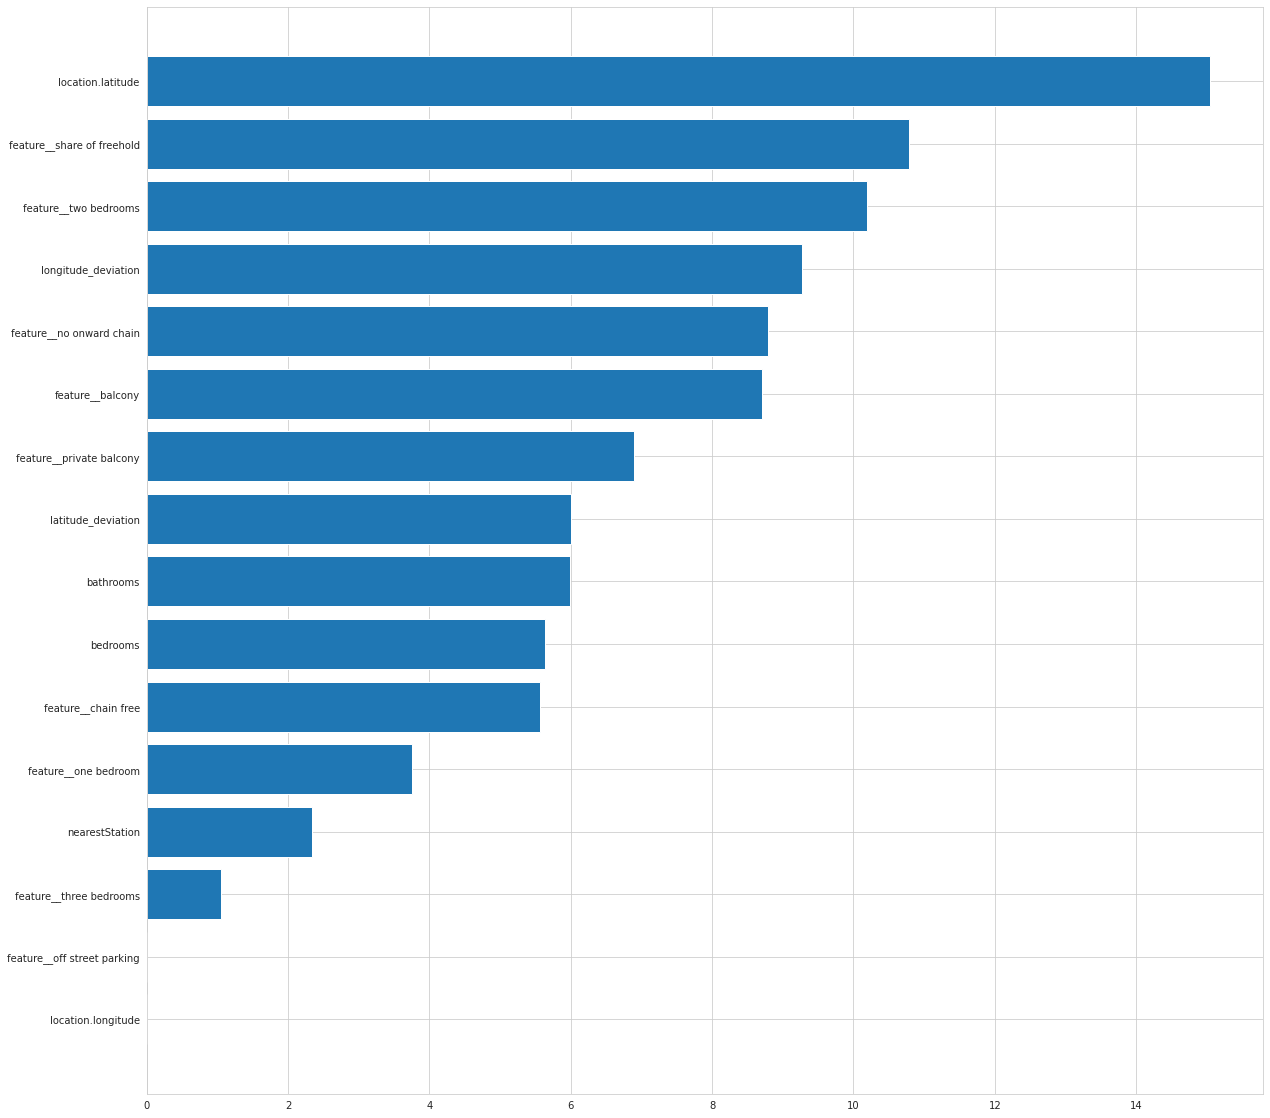

In [42]:
if model_uses_feature_importances:
    indices = np.argsort(feature_importances)

    feature_importance_fig, best_model_ax = plt.subplots(figsize=(20, 20))
    best_model_ax.barh(range(len(feature_importances)), feature_importances[indices])
    best_model_ax.set_yticks(range(len(feature_importances)))
    _ = best_model_ax.set_yticklabels(df_features.columns[[c + 1 for c in indices]])
else:
    print(f'{ALGORITHM} does not have feature_importances, skipping')

<code style="background:blue;color:blue">**********************************************************************************************************</code>

## Stage: Write the final report for this algorithm and dataset version

In [43]:
from bs4 import BeautifulSoup


def include_in_html_report(type, section_header=None, section_figure=None, section_content=None,
                           section_content_list=None):
    # writePath_html = r'model_results/%s (html).html' % key
    # writePath_md = r'model_results/%s (md).md' % key
    results_root = '../../F_evaluate_model'
    writePath_html = f'{results_root}/html/{key}.html'.replace(" ", "_").replace("(", "_").replace(")", "_")
    writePath_md = f'{results_root}/markdown/{key}.md'

    #isinstance(ini_list2, list)
    if not section_content_list:
        section_content_list = [section_content]

    if type == 'header':
        w = 'w' if section_figure <= 1 else 'a'
        with open(writePath_html, w) as f1:
            headers = f'<h{section_figure}>{section_content}</h{section_figure}>'
            f1.write(headers)
        with open(writePath_md, w) as f2:
            headers = f'{"#" * int(section_figure)} {section_content}\n'
            f2.write(headers)
    else:
        if section_header:
            with open(writePath_html, 'a') as f1:
                f1.write(f'<h3>{section_header}</h3>')
            with open(writePath_md, 'a') as f2:
                f2.write(f'### {section_header}\n')

        if type == 'dataframe':
            with open(writePath_html, 'a') as f1:
                dfAsString = section_content.to_html()
                f1.write(dfAsString)
            with open(writePath_md, 'a') as f2:
                dfAsString = section_content.to_markdown()
                f2.write(dfAsString + '\n')
        elif type == 'graph':
            filename = key + "_" + section_content
            #section_figure.savefig(f'model_results/artifacts/{filename.replace(" ", "_")}')
            section_figure.savefig(
                f'{results_root}/artifacts/{filename.replace(" ", "_").replace("(", "_").replace(")", "_")}')

            with open(writePath_html, 'a') as f1:
                dfAsString = f'<img src="../artifacts/{filename.replace(" ", "_").replace("(", "_").replace(")", "_")}"/>'
                f1.write(dfAsString)

            with open(writePath_md, 'a') as f2:
                #dfAsString = f'(./model_results/artifacts/{filename}) \n'
                #dfAsString = f'![detail](./artifacts/{filename.replace(" ","_")})'
                dfAsString = f'![detail](../artifacts/{filename.replace(" ", "_").replace("(", "_").replace(")", "_")})'
                f2.write(dfAsString)
                f2.write('\n')
        elif type == 'json':

            # html_content_parsed = [[cell.text for cell in row("td")]
            #              for row in BeautifulSoup(content,features="html.parser")("tr")]
            #
            # html_content_dictionary = {element[0]:element[1:] for element in html_content_parsed}

            #xxxprint(json.dumps(html_content_dictionary, indent=4))

            with open(writePath_html, 'a') as f1:
                #f.write(json.dumps(html_content_dictionary, indent=4))
                soup = BeautifulSoup(section_content, "html.parser")
                f1.write(str(soup.prettify()))
            with open(writePath_md, 'a') as f2:
                #f.write(json.dumps(html_content_dictionary, indent=4))
                soup = BeautifulSoup(section_content, "html.parser")
                #f2.write(str(soup.prettify()))

                # html_content_dictionary = {element[0]:element[1:] for element in html_content_parsed}
                # f2.write(json.dumps(html_content_dictionary, indent=4))

                import ast
                loads = ast.literal_eval(section_content)
                #df = pd.DataFrame.from_dict(loads)
                #df.drop(['dont'], axis=1, inplace=True)
                #print(df.to_markdown(index=False,tablefmt='fancy_grid'))
                for each in loads:
                    f2.write(each + " = " + str(loads[each]) + "\n\n")

        elif type == 'dict':

            for section_content in section_content_list:
                if isinstance(section_content, str):
                    import ast
                    section_content = ast.literal_eval(section_content)

                with open(writePath_html, 'a') as f1:
                    soup = BeautifulSoup(str(section_content), "html.parser")
                    f1.write(str(soup.prettify()))
                with open(writePath_md, 'a') as f2:
                    for each in section_content:
                        f2.write(each + " = " + str(section_content[each]) + "\n\n")

        elif type == 'text':
            with open(writePath_html, 'a') as f1:
                for each_line in section_content_list:
                    f1.write(each_line + '<br>')
            with open(writePath_md, 'a') as f2:
                for each_line in section_content_list:
                    f2.write(each_line + '\n\n')

        with open(writePath_html, 'a') as f1:
            f1.write('<hr>')


include_in_html_report("header", section_content=f"Results from {ALGORITHM}", section_figure=1)

end_timestamp = datetime.now()

include_in_html_report(type="text", section_header=f"Dataset Version: {VERSION}", section_content_list=[
    f"Date run: {datetime.now()}"
    "",
    f"Start time: {start_timestamp}",
    f"End time: {end_timestamp}",
])
include_in_html_report("header", section_content=f"Results", section_figure=2)

include_in_html_report(type="text", section_header="Summary", section_content=new_model_decision)

#include_in_html_report(type="dataframe",text_single="Tuned Models ranked by performance", content=cv_results_df_sorted)

if not using_catboost:
    include_in_html_report(type='dataframe',
                           section_header='Tuned Models ranked by performance, with parameter details',
                           section_content=cv_results_df_summary)

    include_in_html_report(type='graph', section_header='Best and worst models obtained by tuning',
                           section_figure=worst_and_best_model_fig, section_content="best_and_worst.png")

    include_in_html_report(type='graph',
                           section_header='Best Model: Comparing model predictions to actual property values',
                           section_figure=best_model_fig, section_content='best_model_correlation.png')
else:  #if using_catboost:
    include_in_html_report(type="text", section_header="Model Specific Notes",
                           section_content_list=["can't display hyperparameter comparison for catboost",
                                                 "can't display model performance graphs for catboost",
                                                 "can't display model performance graphs for catboost"])

if model_uses_feature_importances:
    include_in_html_report("header", section_content=f"Feature Importances", section_figure=2)
    include_in_html_report(type="text", section_header="Feature Importances",
                           section_content=feature_importances_output)
    include_in_html_report(type="graph", section_header=f"Feature Importances ({ALGORITHM})",
                           section_figure=feature_importance_fig, section_content='best_model_feature_importances.png')

include_in_html_report("header", section_content=f"Comparison with other models", section_figure=2)

dff = pd.read_json('../../../results/results.json')

version = VERSION

all_models_df = dff[dff.columns].T.sort_values("best score", ascending=False)
version_models_df = dff[[c for c in dff.columns if version in c]].T.sort_values("best score", ascending=False)

version_models_summary = version_models_df[
    ['best score', 'best time', 'Mean Absolute Error Accuracy', 'Mean Squared Error Accuracy', 'R square Accuracy',
     'Root Mean Squared Error', 'best run date', 'best method']]
all_models_summary = all_models_df[
    ['best score', 'best time', 'Mean Absolute Error Accuracy', 'Mean Squared Error Accuracy', 'R square Accuracy',
     'Root Mean Squared Error', 'best run date', 'best method']]

include_in_html_report(type="dataframe", section_header=f"Comparison with version {VERSION} performances",
                       section_content=version_models_summary)
include_in_html_report(type="dataframe", section_header="Comparison with all model performances",
                       section_content=all_models_summary)

include_in_html_report("header", section_content=f"Appendix", section_figure=2)

include_in_html_report(type="dataframe", section_header="Data Sample", section_content=df.head(5))

include_in_html_report(type="json", section_header="Hyperparameter options for Randomized Grid Search",
                       section_content=f"{param_options if not using_catboost else options_block}")

if not using_catboost:
    include_in_html_report(type="graph", section_header=f"Range of hyperparameter results",
                           section_figure=evolution_of_models_fig,
                           section_content='evolution_of_models_fig.png')

include_in_html_report(type="dict", section_header="Environment Variables", section_content=env_vars)


def print_and_report(text_single, title):
    include_in_html_report("text", section_content=title)
    for each in text_single:
        print(each)
        include_in_html_report("text", section_header="", section_content=each)

# if not catboost:
#     print_and_report([
#         'Best Index:' + str(crossval_runner.best_index_) + '<br>',
#         'Best Score:' + str(crossval_runner.best_score_) + '<br>',
#         'Best Params: ' + str(crossval_runner.best_params_) + '<br>'
#     ], "Best Model Details")



In [44]:
print('Nearly finished...')

Nearly finished...


In [45]:
# !jupyter nbconvert --to script mycode.ipynb
# with open('it10_all_models_20221203.ipynb', 'r') as f:
#     lines = f.readlines()
# with open('mycode.py', 'w') as f:
#     for line in lines:
#         if 'nbconvert --to script' in line:
#             break
#         else:
#             f.write(line)

if create_python_script and is_jupyter:
    !jupyter nbconvert --to script 'all_models_except_neural_networks_with_autoencoding.ipynb'

#!jupyter nbconvert --to script 'it10_all_models_20221203.ipynb' &&  \
#!mv ./folder/notebooks/*.py ./folder/python_scripts && \

[NbConvertApp] WARNING | pattern 'all_models_except_neural_networks_with_autoencoding.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--J

In [46]:
print(f'ALGORITHM: {ALGORITHM}')
print(f'ALGORITHM_DETAIL: {ALGORITHM_DETAIL}')
print(f'DATA VERSION: {VERSION}')
print(f'DATA_DETAIL: {DATA_DETAIL}')


In [46]:
print('Finished!')

Finished!
